### Reading the data and some initial analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext, Row

from pyspark.sql.types import *
from pyspark.sql.types import StructType,StructField, StringType
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [2]:
spark = SparkSession.builder.appName('Project').getOrCreate()

#### Loading the data

In [ ]:
df = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load('/FileStore/tables/HR_comma_sep.csv')

In [ ]:
df.show(5)

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|Department|salary|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
|              0.38|           0.53|             2|                 157|                 3|            0|   1|                    0|     sales|   low|
|               0.8|           0.86|             5|                 262|                 6|            0|   1|                    0|     sales|medium|
|              0.11|           0.88|             7|                 272|                 4|            0|   1|                    0|     sales|medium|
|              0.72|           0.87|             5|                 223|                 5|   

In [ ]:
print("Shape of the dataframe is: ", df.count(), "rows and", len(df.columns), "columns")

Shape of the dataframe is:  14999 rows and 10 columns


In [ ]:
df.printSchema()

root
 |-- satisfaction_level: double (nullable = true)
 |-- last_evaluation: double (nullable = true)
 |-- number_project: integer (nullable = true)
 |-- average_montly_hours: integer (nullable = true)
 |-- time_spend_company: integer (nullable = true)
 |-- Work_accident: integer (nullable = true)
 |-- left: integer (nullable = true)
 |-- promotion_last_5years: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- salary: string (nullable = true)



In [ ]:
df.dtypes

Out[7]: [('satisfaction_level', 'double'),
 ('last_evaluation', 'double'),
 ('number_project', 'int'),
 ('average_montly_hours', 'int'),
 ('time_spend_company', 'int'),
 ('Work_accident', 'int'),
 ('left', 'int'),
 ('promotion_last_5years', 'int'),
 ('Department', 'string'),
 ('salary', 'string')]

In [ ]:
def feature_identification(df):

    categorical_features = []
    numerical_features = []

    for col in df.dtypes:
      if col[1] == 'string':
        categorical_features.append(col[0])
      else:
        numerical_features.append(col[0])

    i=len(categorical_features)
    j=len(numerical_features)
    
    print('There are {} categorical features and {} numerical features'.format(i,j),'\n')
    print('categorical features={}'.format(sorted(categorical_features)),'\n')
    print('numerical features={}'.format(sorted(numerical_features)),'\n')
    
    return (categorical_features,numerical_features)

categorical_features, numerical_features = feature_identification(df)

There are 2 categorical features and 8 numerical features 

categorical features=['Department', 'salary'] 

numerical features=['Work_accident', 'average_montly_hours', 'last_evaluation', 'left', 'number_project', 'promotion_last_5years', 'satisfaction_level', 'time_spend_company'] 



In [ ]:
for colName in df.columns:
    print("Unique values for column '{0}' are: {1}".format(
        colName, df.select(colName).distinct().count()))

Unique values for column 'satisfaction_level' are: 92
Unique values for column 'last_evaluation' are: 65
Unique values for column 'number_project' are: 6
Unique values for column 'average_montly_hours' are: 215
Unique values for column 'time_spend_company' are: 8
Unique values for column 'Work_accident' are: 2
Unique values for column 'left' are: 2
Unique values for column 'promotion_last_5years' are: 2
Unique values for column 'Department' are: 10
Unique values for column 'salary' are: 3


In [ ]:
from pyspark.sql.functions import isnan, when, count, col

def null_checker(df):
  return df.select([count(when(col(x).isNull(), x)).alias(x) for x in df.columns])
  
null_checker(df).show()

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|Department|salary|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
|                 0|              0|             0|                   0|                 0|            0|   0|                    0|         0|     0|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+



In [ ]:
from pyspark.sql.functions import count as count

df.groupBy('left').agg(count('*').alias('count')).show()

+----+-----+
|left|count|
+----+-----+
|   1| 3571|
|   0|11428|
+----+-----+



In [ ]:
df.groupBy('left').mean().show()

+----+-----------------------+--------------------+-------------------+-------------------------+-----------------------+--------------------+---------+--------------------------+
|left|avg(satisfaction_level)|avg(last_evaluation)|avg(number_project)|avg(average_montly_hours)|avg(time_spend_company)|  avg(Work_accident)|avg(left)|avg(promotion_last_5years)|
+----+-----------------------+--------------------+-------------------+-------------------------+-----------------------+--------------------+---------+--------------------------+
|   1|    0.44009801176140917|  0.7181125735088183| 3.8555026603192384|       207.41921030523662|      3.876505180621675|0.047325679081489776|      1.0|      0.005320638476617194|
|   0|      0.666809590479516|  0.7154733986699274|  3.786664333216661|        199.0602030101505|     3.3800315015750786| 0.17500875043752187|      0.0|      0.026251312565628283|
+----+-----------------------+--------------------+-------------------+-------------------------+---

#### Exploratory Data Analysis

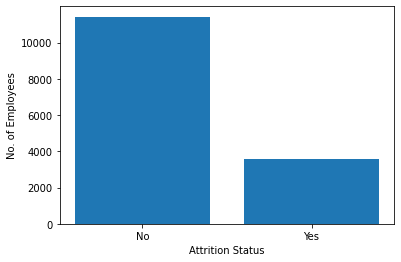

In [ ]:
count_left = df.groupby('left').count().toPandas()
index = ['Yes', 'No']
x = count_left['left'].tolist()
y = count_left['count'].tolist()
plt.bar(x, y)
plt.xticks(x, labels=index)
plt.xlabel("Attrition Status")
plt.ylabel("No. of Employees")
plt.show()

Out[14]: <AxesSubplot:xlabel='Department', ylabel='count'>

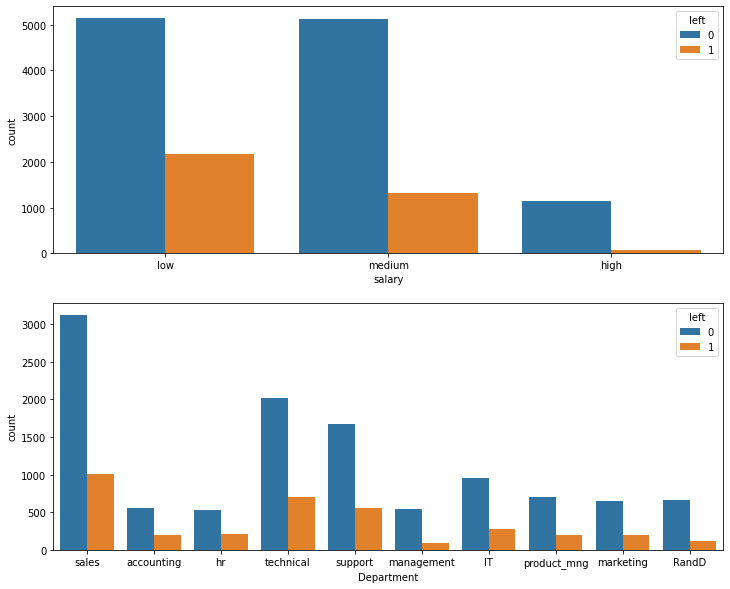

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
sns_df = df.toPandas()

sns.countplot(x='salary', hue='left', data=sns_df, ax=axs[0])
sns.countplot(x='Department', hue='left', data=sns_df, ax=axs[1])

The above plots show that mostly those with low salaries and working in sales, technical and support departments had a higher rate of attrition.

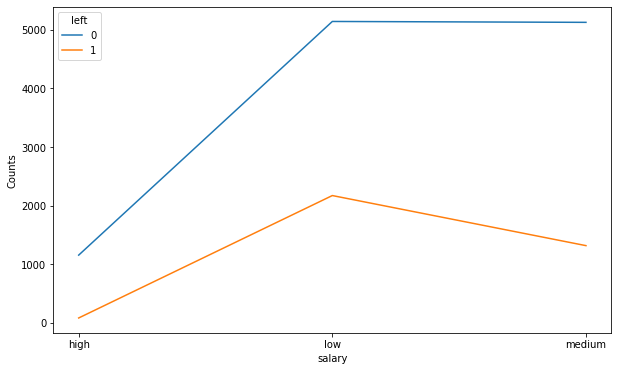

In [ ]:
rate_attrition = df.groupby(['salary', 'left']).agg(count('*').alias('Counts'))
sns_df2 = rate_attrition.toPandas()
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=sns_df2, x='salary', y='Counts', hue='left', ax=ax)
plt.show()

The above plot demonstrates the attrition rates are higher among low income compared to high and medium income group

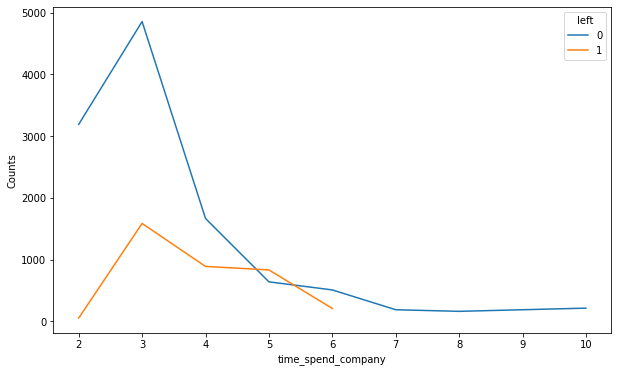

In [ ]:
rate_attrition = df.groupby(['time_spend_company', 'left']).agg(count('*').alias('Counts'))
sns_df2 = rate_attrition.toPandas()
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=sns_df2, x='time_spend_company', y='Counts', hue='left', ax=ax)
plt.show()

The above graphs shows that more than half of the employees left the company within the first 3 years of employment.

Out[17]: <AxesSubplot:>

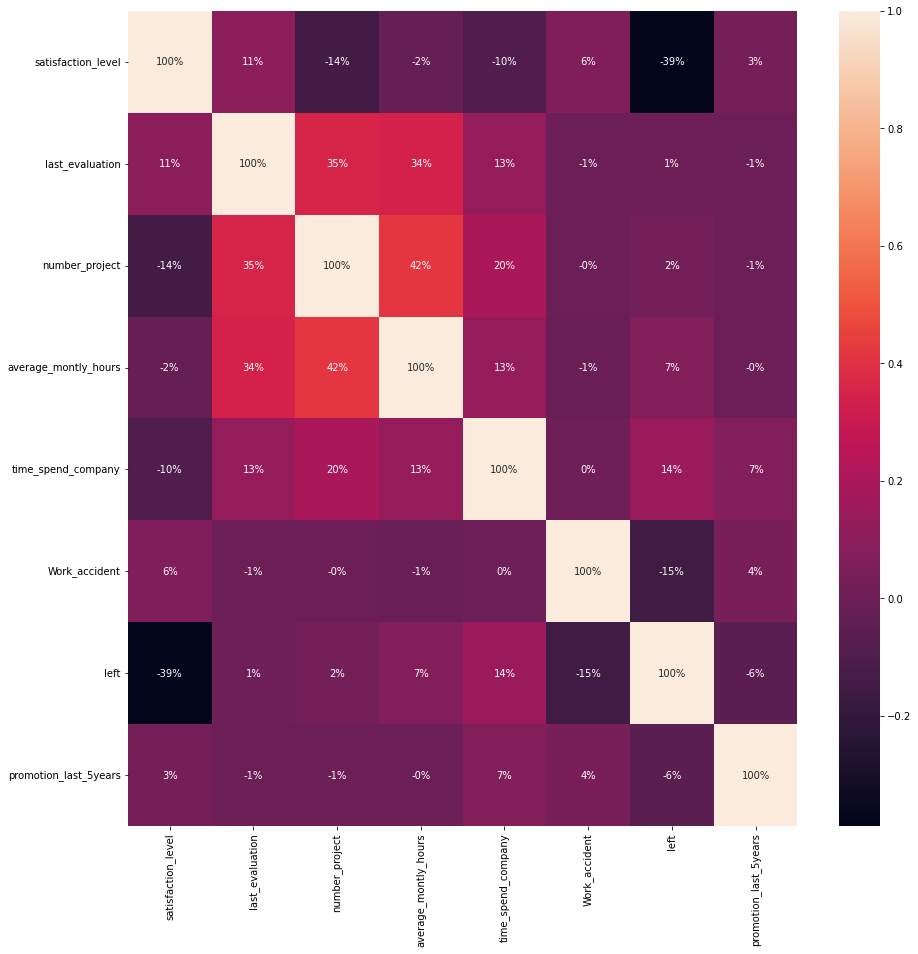

In [ ]:
corr_df = df.toPandas()
plt.figure(figsize=(15,15)) 
sns.heatmap(corr_df.corr(), annot=True, fmt='.0%')

Out[18]: <AxesSubplot:xlabel='promotion_last_5years', ylabel='count'>

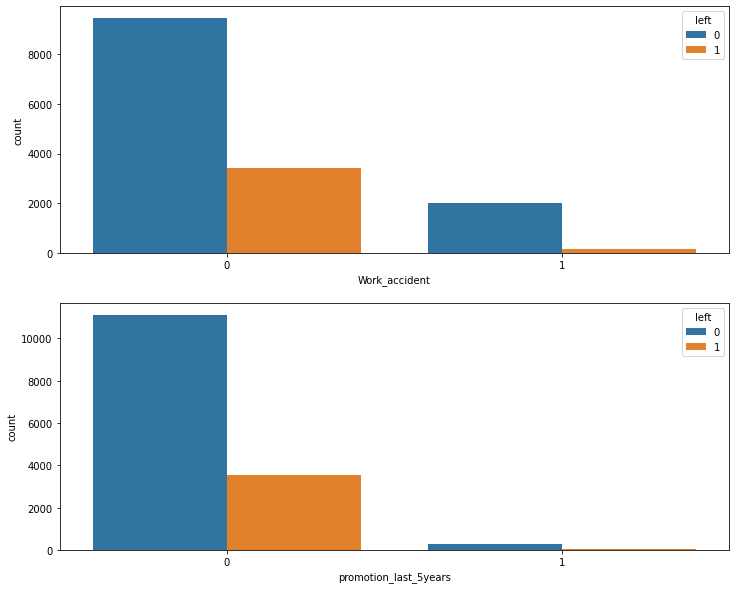

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
sns_df = df.toPandas()

sns.countplot(x='Work_accident', hue='left', data=sns_df, ax=axs[0])
sns.countplot(x='promotion_last_5years', hue='left', data=sns_df, ax=axs[1])

The above graph shpws the reltionship between attrition with features work accident and promotion in the last 5 years

In [ ]:
df.groupBy('left').count().show()

+----+-----+
|left|count|
+----+-----+
|   1| 3571|
|   0|11428|
+----+-----+



#### Pre-processing before Modeling

In [ ]:
# Change categorical features into numerical features
numerical_features = [feature for feature in numerical_features if feature != "left"]

indexed_list = [StringIndexer(inputCol = x, outputCol = x + "_index") for x in categorical_features]
encoded_list = [OneHotEncoder(inputCol = x.getOutputCol(), outputCol = x.getOutputCol() + "_encode") for x in indexed_list]
assembled_list = VectorAssembler(inputCols = [x.getOutputCol() for x in encoded_list] + numerical_features, outputCol = "Features")

In [ ]:
# Start Pipeline for Data
pipeline_test = Pipeline(stages = indexed_list + encoded_list + [assembled_list])
ml_model = pipeline_test.fit(df)
ml_DF = ml_model.transform(df).withColumn('Truth', col("left"))
ml_DF = ml_DF.select("Features", "Truth")
ml_DF.show(10)

+--------------------+-----+
|            Features|Truth|
+--------------------+-----+
|(18,[0,9,11,12,13...|    1|
|(18,[0,10,11,12,1...|    1|
|(18,[0,10,11,12,1...|    1|
|(18,[0,9,11,12,13...|    1|
|(18,[0,9,11,12,13...|    1|
|(18,[0,9,11,12,13...|    1|
|(18,[0,9,11,12,13...|    1|
|(18,[0,9,11,12,13...|    1|
|(18,[0,9,11,12,13...|    1|
|(18,[0,9,11,12,13...|    1|
+--------------------+-----+
only showing top 10 rows



In [ ]:
# Scale
scaler = StandardScaler().setInputCol("Features").setOutputCol("Features_Scaled")
scaler_model = scaler.fit(ml_DF)
scaler_DF = scaler_model.transform(ml_DF)
scaler_DF = scaler_DF.select("Truth", "Features_Scaled")
scaler_DF.show(5)

+-----+--------------------+
|Truth|     Features_Scaled|
+-----+--------------------+
|    1|(18,[0,9,11,12,13...|
|    1|(18,[0,10,11,12,1...|
|    1|(18,[0,10,11,12,1...|
|    1|(18,[0,9,11,12,13...|
|    1|(18,[0,9,11,12,13...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
scaler_DF = scaler_DF.withColumn("Truth",scaler_DF.Truth.cast(DoubleType()))
scaler_DF.show(10)

+-----+--------------------+
|Truth|     Features_Scaled|
+-----+--------------------+
|  1.0|(18,[0,9,11,12,13...|
|  1.0|(18,[0,10,11,12,1...|
|  1.0|(18,[0,10,11,12,1...|
|  1.0|(18,[0,9,11,12,13...|
|  1.0|(18,[0,9,11,12,13...|
|  1.0|(18,[0,9,11,12,13...|
|  1.0|(18,[0,9,11,12,13...|
|  1.0|(18,[0,9,11,12,13...|
|  1.0|(18,[0,9,11,12,13...|
|  1.0|(18,[0,9,11,12,13...|
+-----+--------------------+
only showing top 10 rows



#### Machine Learning

In [ ]:
# Perform train-test split
train_df, test_df = scaler_DF.randomSplit([0.8,0.2])

print('Train dataset: ', train_df.count(), ", percentage of train dataset: ", "{:.0%}".format(train_df.count()/scaler_DF.count()))
print('Test dataset: ', test_df.count(), ", percentage of test dataset: ", "{:.0%}".format(test_df.count()/scaler_DF.count()))

Train dataset:  12020 , percentage of train dataset:  80%
Test dataset:  2979 , percentage of test dataset:  20%


In [ ]:
# Evaluation Metrics
evaluation_binary = BinaryClassificationEvaluator(labelCol = "Truth")
evaluation_multi = MulticlassClassificationEvaluator(labelCol = "Truth")

In [ ]:
def evaluation_values(predictions, binary, multi):
    AUC = evaluation_binary.evaluate(predictions, {binary.metricName: 'areaUnderROC'})
    AUC_pr = evaluation_binary.evaluate(predictions, {binary.metricName: 'areaUnderPR'})

    F1 = multi.evaluate(predictions, {multi.metricName: 'f1'})
    Accuracy = multi.evaluate(predictions, {multi.metricName: 'accuracy'})
    Precision = multi.evaluate(predictions, {multi.metricName: 'weightedPrecision'})
    Recall = multi.evaluate(predictions, {multi.metricName: 'weightedRecall'})

    return {"AUC" : AUC, 
            "AUC_pr" : AUC_pr, 
            "F1" : F1, 
            "Accuracy" : Accuracy, 
            "Precision" : Precision, 
            "Recall": Recall}

In [ ]:
def plot_ROC(model, model_name):
    plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f"ROC Graph of {model_name} Model")
    plt.plot(model.bestModel.summary.roc.select("FPR").collect(),
             model.bestModel.summary.roc.select("TPR").collect())
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [ ]:
def plot_confusion_matrix(predictions, model_name):
    cm = MulticlassMetrics(predictions.select(['prediction', 'Truth']).rdd.map(tuple)).confusionMatrix().toArray()
    cm_norm = cm / np.sum(cm)
    
    fig, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(cm_norm, annot = True, cmap = "vlag", ax = ax)
    plt.title(f"Confusion Matrix of {model_name} Model")
    ax.set_xticklabels(["yes", "no"])
    ax.set_yticklabels(["yes", "no"])
    plt.xlabel("Actual Truth")
    plt.ylabel("Predicted Truth")
    plt.show()

In [ ]:
def model_creation(model, grid, binary, train_df, test_df):
    cv = CrossValidator(estimator = model, estimatorParamMaps = param_grid, evaluator = binary, numFolds = 5)
    ml_model = cv.fit(train_df)
    ml_predictions = ml_model.transform(test_df)
    
    return ml_model, ml_predictions

##### Logistic Regression Model

In [ ]:
# Logistic Regression model
lr = LogisticRegression(featuresCol = "Features_Scaled", labelCol = "Truth")

# Define the parameter grid for cross-validation
param_grid = (ParamGridBuilder()
              .addGrid(lr.regParam, [0.1, 0.01])
              .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
              .addGrid(lr.maxIter, [10, 100])
              .build())

lr_model, lr_predictions = model_creation(lr, param_grid, evaluation_binary, train_df, test_df)
lr_predictions.select("Truth", "prediction").show(10)

+-----+----------+
|Truth|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
+-----+----------+
only showing top 10 rows



In [ ]:
lr_dict = evaluation_values(lr_predictions, evaluation_binary, evaluation_multi)
lr_dict

Out[33]: {'AUC': 0.8167477415306676,
 'AUC_pr': 0.5268901976275833,
 'F1': 0.7531071734773648,
 'Accuracy': 0.7797918764686136,
 'Precision': 0.7519577766415809,
 'Recall': 0.7797918764686136}

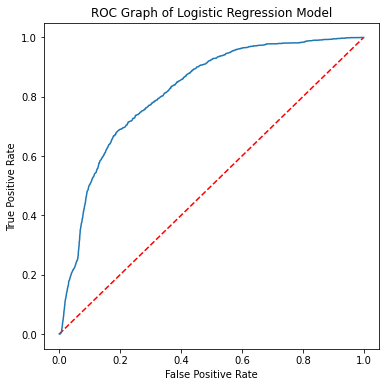

In [ ]:
plot_ROC(lr_model, "Logistic Regression")

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


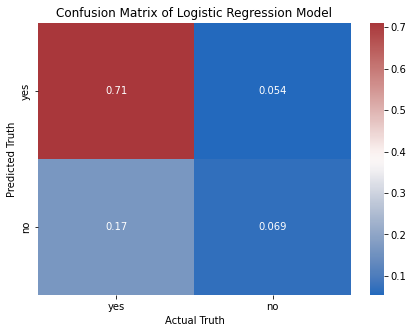

In [ ]:
plot_confusion_matrix(lr_predictions, "Logistic Regression")

##### Random Forest Model

In [ ]:
# Create a Random Forest classifier
rf = RandomForestClassifier(featuresCol = "Features_Scaled", labelCol = "Truth")

# Define the parameter grid for cross-validation
param_grid = (ParamGridBuilder()
              .addGrid(rf.numTrees, [10, 20])
              .addGrid(rf.maxDepth, [5, 10])
              .addGrid(rf.impurity, ['gini', 'entropy'])
              .build())

rf_model, rf_predictions = model_creation(rf, param_grid, evaluation_binary, train_df, test_df)
rf_predictions.select("Truth", "prediction").show(10)

+-----+----------+
|Truth|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 10 rows



In [ ]:
rf_dict = evaluation_values(rf_predictions, evaluation_binary, evaluation_multi)
rf_dict

Out[37]: {'AUC': 0.9851369359462748,
 'AUC_pr': 0.9745665147202159,
 'F1': 0.9717666305047306,
 'Accuracy': 0.9721383014434374,
 'Precision': 0.9722093886100325,
 'Recall': 0.9721383014434375}

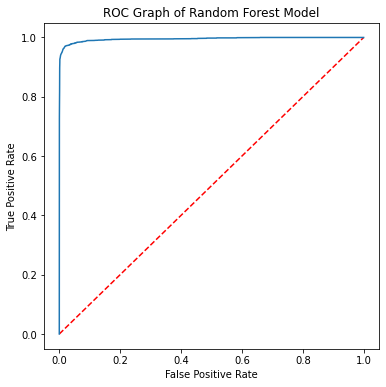

In [ ]:
plot_ROC(rf_model, "Random Forest")

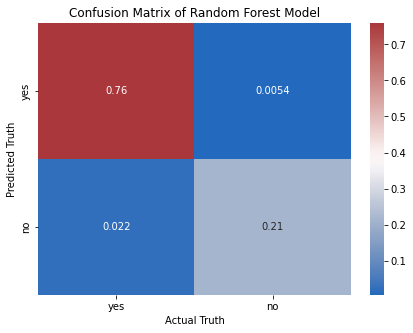

In [ ]:
plot_confusion_matrix(rf_predictions, "Random Forest")

##### Decision Tree Model

In [ ]:
# Create a decision tree classifier
dt = DecisionTreeClassifier(featuresCol = "Features_Scaled", labelCol = "Truth")

# Define the parameter grid for cross-validation
param_grid = (ParamGridBuilder()
              .addGrid(dt.maxDepth, [2, 5, 10])
              .addGrid(dt.maxBins, [10, 20, 30])
              .build())

dt_model, dt_predictions = model_creation(dt, param_grid, evaluation_binary, train_df, test_df)
dt_predictions.select("Truth", "prediction").show(10)

+-----+----------+
|Truth|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 10 rows



In [ ]:
dt_dict = evaluation_values(dt_predictions, evaluation_binary, evaluation_multi)
dt_dict

Out[41]: {'AUC': 0.9512304634417909,
 'AUC_pr': 0.9217110503687937,
 'F1': 0.9684841061462387,
 'Accuracy': 0.9687814702920443,
 'Precision': 0.96860645717556,
 'Recall': 0.9687814702920443}

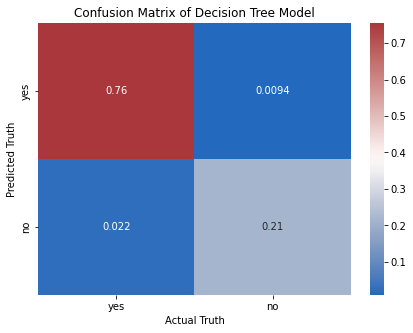

In [ ]:
plot_confusion_matrix(dt_predictions, "Decision Tree")

##### Linear Support Vector Machine

In [ ]:
# Define the SVM model
svm = LinearSVC(featuresCol = "Features_Scaled", labelCol = "Truth")

# Define the parameter grid for cross-validation
param_grid = (ParamGridBuilder()
              .addGrid(svm.regParam, [0.1, 0.01])
              .addGrid(svm.maxIter, [10, 100])
              .build())

svm_model, svm_predictions = model_creation(svm, param_grid, evaluation_binary, train_df, test_df)
svm_predictions.select("Truth", "prediction").show(10)

+-----+----------+
|Truth|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
+-----+----------+
only showing top 10 rows



In [ ]:
svm_dict = evaluation_values(svm_predictions, evaluation_binary, evaluation_multi)
svm_dict

Out[44]: {'AUC': 0.8013041697612505,
 'AUC_pr': 0.5773974287818275,
 'F1': 0.7488700696515181,
 'Accuracy': 0.7811346089291709,
 'Precision': 0.7518539331848941,
 'Recall': 0.7811346089291709}

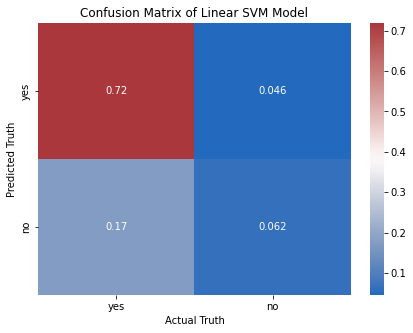

In [ ]:
plot_confusion_matrix(svm_predictions, "Linear SVM")

##### Naive Bayes

In [ ]:
# Define the Naive Bayes model
nb = NaiveBayes(featuresCol = "Features_Scaled", labelCol = "Truth")

# Define the parameter grid for cross-validation
param_grid = (ParamGridBuilder()
              .addGrid(nb.smoothing, [0.1, 0.5, 1])
              .build())

nb_model, nb_predictions = model_creation(nb, param_grid, evaluation_binary, train_df, test_df)
nb_predictions.select("Truth", "prediction").show(10)

+-----+----------+
|Truth|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
+-----+----------+
only showing top 10 rows



In [ ]:
nb_dict = evaluation_values(nb_predictions, evaluation_binary, evaluation_multi)
nb_dict

Out[47]: {'AUC': 0.5689182266898287,
 'AUC_pr': 0.33746751061734553,
 'F1': 0.7305295075546177,
 'Accuracy': 0.760657938905673,
 'Precision': 0.7245496187452425,
 'Recall': 0.760657938905673}

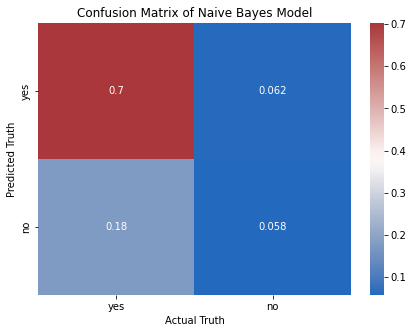

In [ ]:
plot_confusion_matrix(nb_predictions, "Naive Bayes")

##### Gradient-Boosted Trees

In [ ]:
# Define the Gradient-Boosted Trees model
gbt = GBTClassifier(featuresCol = "Features_Scaled", labelCol = "Truth")

# Define the parameter grid for cross-validation
param_grid = (ParamGridBuilder()
              .addGrid(gbt.maxDepth, [2, 5])
              .addGrid(gbt.maxBins, [10, 20])
              .build())

gbt_model, gbt_predictions = model_creation(gbt, param_grid, evaluation_binary, train_df, test_df)
gbt_predictions.select("Truth", "prediction").show(10)

+-----+----------+
|Truth|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 10 rows



In [ ]:
gbt_dict = evaluation_values(gbt_predictions, evaluation_binary, evaluation_multi)
gbt_dict

Out[50]: {'AUC': 0.9792899019211231,
 'AUC_pr': 0.9645863703734837,
 'F1': 0.9650953003555119,
 'Accuracy': 0.9654246391406512,
 'Precision': 0.9651829255035494,
 'Recall': 0.9654246391406512}

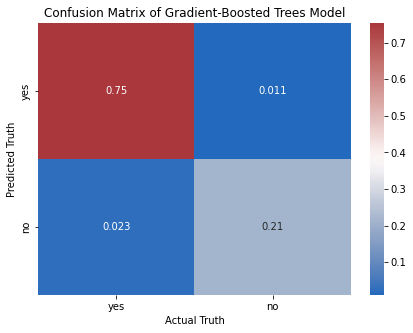

In [ ]:
plot_confusion_matrix(gbt_predictions, "Gradient-Boosted Trees")

In [ ]:
# All values from the models
values_list = []
metrics_list = [lr_dict, rf_dict, dt_dict, svm_dict, nb_dict, gbt_dict]
for metric in lr_dict:
    metric_dict = {"Metric" : metric}
    for i, label in enumerate(labels):
        metric_dict[label] = metrics_list[i][metric]
    values_list.append(metric_dict)

metrics_DF = spark.createDataFrame(values_list)
metrics_DF.select('Metric', 'Logistic Regression', 'Random Forest', 'Decision Tree', 'Linear SVM', 'Naive Bayes', 'Gradient-Boosted Tree').show()

+---------+-------------------+------------------+------------------+------------------+-------------------+---------------------+
|   Metric|Logistic Regression|     Random Forest|     Decision Tree|        Linear SVM|        Naive Bayes|Gradient-Boosted Tree|
+---------+-------------------+------------------+------------------+------------------+-------------------+---------------------+
|      AUC| 0.8167477415306676|0.9851369359462748|0.9512304634417909|0.8013041697612505| 0.5689182266898287|   0.9792899019211231|
|   AUC_pr| 0.5268901976275833|0.9745665147202159|0.9217110503687937|0.5773974287818275|0.33746751061734553|   0.9645863703734837|
|       F1| 0.7531071734773648|0.9717666305047306|0.9684841061462387|0.7488700696515181| 0.7305295075546177|   0.9650953003555119|
| Accuracy| 0.7797918764686136|0.9721383014434374|0.9687814702920443|0.7811346089291709|  0.760657938905673|   0.9654246391406512|
|Precision| 0.7519577766415809|0.9722093886100325|  0.96860645717556|0.751853933184

Random forest, Decision Tree and Gradient Boost turned out to be the best models, with Random Forest accuracy being slightly higher than the other two.